# Question 1: Spectral Clustering

We will study a political blogs dataset first compiled for the paper Lada A. Adamic and Natalie Glance,
“The political blogosphere and the 2004 US Election”, in Proceedings of the WWW-2005 Workshop on the
Weblogging Ecosystem (2005). It is assumed that blog-site with the same political orientation are more
likely to link to each other, thus, forming a “community” or “cluster” in a graph. In this question, we will
see whether or not this hypothesis is likely to be true based on data.
• The dataset nodes.txt contains a graph with n = 1490 vertices (“nodes”) corresponding to political
blogs.
• The dataset edges.txt contains edges between the vertices. You may remove isolated nodes (nodes that
are not connected any other nodes) in the pre-processing.
We will treat the network as an undirected graph; thus, when constructing the adjacency matrix, make
it symmetrical by, e.g., set the entry in the adjacency matrix to be one whether there is an edge between
the two nodes (in either direction).
In addition, each vertex has a 0-1 label (in the 3rd column of the data file) corresponding to the true
political orientation of that blog. We will consider this as the true label and check whether spectral clustering
will cluster nodes with the same political orientation as possible

**1. Assume the number of clusters in the graph is k. Explain the meaning of k here intuitively.**

K is the number of cluster we expect to see in our graph. The clusters will be the connected communities in the network. Because spectral clustering clusters based on connectivity, when assuming K, we would try to pick a number that might be close to the actuall number of communities. After this, we can tune K by choosing different values and comparing accuracy rates.

In [35]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.cluster import KMeans
from scipy.linalg import fractional_matrix_power
from scipy import sparse
import sys
# import seaborn as sns
# sns.set()

floatformat = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':floatformat})
# np.set_printoptions(threshold=100)

In [36]:
edges = pd.read_table("data/edges.txt", names = ["to", "from"])
allnums = sorted(list(set(pd.concat([edges["to"], edges['from']]))))
# edges[edges['from'] == 200].head()
keepind = [x-1 for x in allnums]
keepind = np.array(keepind)
# keepind[:5]
# allnums[:20]

Read in Nodes data:

In [39]:
nodes = pd.read_table("data/nodes.txt", names = ["node", "blog", "label", "company"])

# nodelabels = dict(zip(nodes["node"]-1, nodes["label"]))
# nodeinds = dict(zip(nodes["node"]-1, nodes["node"]))
# nodelabels
# nodes = nodes.iloc[keepind,:]
nodes.head()

,node,blog,label,company
0,1,100monkeystyping.com,0,Blogarama
1,2,12thharmonic.com/wordpress,0,BlogCatalog
2,3,40ozblog.blogspot.com,0,"Blogarama,BlogCatalog"
3,4,4lina.tblog.com,0,Blogarama
4,5,750volts.blogspot.com,0,Blogarama


In [38]:
#reindexing
reindexnodes = {}
skipped = 0
for i, n in nodes.iterrows():
#     print(n)
    reindexnodes[i] = {}
    reindexnodes[i]['label'] = n.loc['label']
    reindexnodes[i]['blog'] = n.loc['blog']
    if i in keepind:
        reindexnodes[i]['reindex'] = i-skipped
    else:
        skipped += 1
        reindexnodes[i]['reindex'] = 'none'
# reindexnodes
        # for x in nodes: 
    

Read in Edges data:

In [40]:
for i, r in edges.iterrows():
    r.loc['to'] = reindexnodes[r.loc['to']-1]['reindex']
    r.loc['from'] = reindexnodes[r.loc['from']-1]['reindex']
    
# max(edges['to'])
edges.head()

,to,from
0,208,1138
1,208,376
2,208,839
3,718,1214
4,718,730


In [41]:
newnodelabels = {}
newnodeinds = {}
for x, y in reindexnodes.items():
    if y['reindex'] is not 'none':
        newnodelabels[y['reindex']] = y['label']
        newnodeinds[y['reindex']] = y['reindex']

# newnodeinds

In [42]:
G = nx.from_pandas_edgelist(edges, 'to', 'from')
nx.set_node_attributes(G, newnodelabels, "label")
nx.set_node_attributes(G, newnodeinds, "index")

# G.nodes(data=True)
# max(G.nodes)

Graphing the true labels with force directed layout:

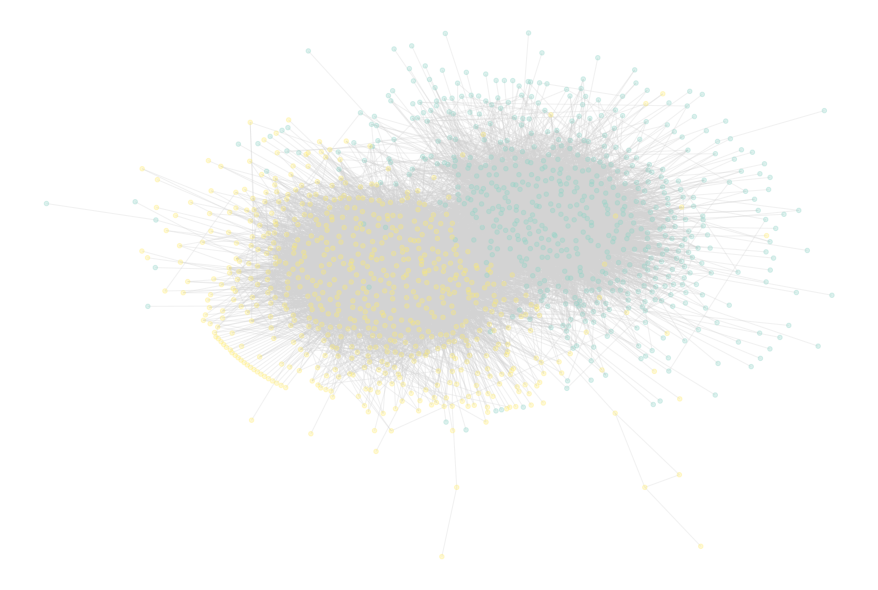

In [13]:

plt.figure(figsize=(12,8))
nx.draw_kamada_kawai(G, alpha=0.3, node_size = 20, node_color=[x[1]['label'] for x in G.nodes(data=True)], edge_color = "lightgrey", cmap = plt.cm.Set3)


In [43]:
# i = edges.to_numpy()[:, 0]
# max(i)
# max(edges['to'])


In [44]:
# A = nx.adjacency_matrix(G, nodelist = sorted(nodes["node"]))
# A = nx.adjacency_matrix(G)

i = edges.to_numpy()[:, 0]
j = edges.to_numpy()[:, 1]
v = np.ones((edges.to_numpy().shape[0], 1)).flatten()
n = len(newnodeinds)
A = sparse.coo_matrix((v, (i, j)), shape=(n, n))
A = (A + np.transpose(A))/2
# A = A[keepind]
# A = A[:,keepind]

# keep = np.any(A.todense())
# A = A.todense()[keep,:]
# print(A.todense()[:5])
# A.dtype
# np.allclose(A.todense(), A2.todense(), atol = .6)
# A.todense()[:10]
# A2.todense()[:10]
# print(np.where(A.todense()!=A2.todense()))
# len(A2.todense())
# print(A.shape, A2.shape)
# print(keep)
# print(A.shape)

In [45]:
# D = np.diag(np.sum(np.array(A.todense()), axis=1))
#if row above is active, also active np.flip in cells below
D = np.diag(1/np.sqrt(np.sum(A, axis=1)).A1)
# print(D[:5])
# D.shape

In [46]:
L = D@A@D
# L = D - A
# print(L[:5])

In [47]:
vecs, vals, _ = np.linalg.svd(L)

# vecs = vecs/np.repeat(np.sqrt(np.sum(vecs*vecs, axis=1).reshape(-1, 1)), len(vals), axis=1)
# vals = np.real(np.flip(vals))
# print(vals)

In [48]:
# np.sum(np.imag(vals))

In [49]:
def applykmeans(eigenvectors, kclusters):
    v = eigenvectors[:,:kclusters]
#     v = v/np.repeat(np.sqrt(np.sum(v*v, axis=1).reshape(-1, 1)), kclusters, axis=1)
    model = KMeans(n_clusters = kclusters, init = "random")
    model.fit(vecs[:,:kclusters])
    return model.labels_

# print(np.unique(applykmeans(vecs, 5), return_counts=True))
# print(applykmeans(vecs, 5))

**2. Use spectral clustering to find the k = 2, 5, 10, 20 clusters in the network of political blogs
(each node is a blog, and their edges are defined in the file edges.txt). Then report the majority labels
in each cluster, for different k values, respectively. For example, if there are k = 2 clusters, and their
labels are {0, 1, 1, 1} and {0, 0, 1} then the majority label for the first cluster is 1 and for the second
cluster is 0. It is required you implementing the algorithms yourself rather than calling
from a package.**

and

**3. Now compare the majority label with the individual labels in each cluster, and report the
mismatch rate for each cluster, when k = 2, 5, 10, 20. For instance, in the example above, the mismatch
rate for the first cluster is 1/4 (only the first node differs from the majority) and the the second cluster
is 1/3**


In [50]:
ks = [2,5,10,20]
results = []

for k in ks:
    res = applykmeans(vecs, k)
    results.append(res)
    unique, counts = np.unique(res, return_counts=True)
#     print(f" cluster results for {k}: {np.asarray((unique, counts)).T}")

In [51]:
for i, labs in enumerate(results):
    print(f"Statistics for k = {len(set(labs))}")
    mismatchcounter = 0
    for ind, lab in enumerate(set(labs)):
        incluster = [y for y, x in enumerate(labs) if x == lab]
        clustertruth = [newnodelabels[z] for z in incluster]
        majority = np.argmax(np.bincount(clustertruth))
        clustersize = len(incluster)
#         clustermatches = len()
        matches = [z for z in incluster if newnodelabels[z] == majority]
        clustermatches = len(matches)
        mismatch = (clustersize - clustermatches)/clustersize
        mismatchcounter += (clustersize - clustermatches)
        print(f"Mismatch rate for cluster {lab}: {round(mismatch, 3)} --majority of {clustersize} obs: {majority}")
    print(f"Total Mismatches: {mismatchcounter} of {len(labs)}, {round(mismatchcounter / len(labs), 3)} \n")

Statistics for k = 2
Mismatch rate for cluster 0: 0.476 --majority of 843 obs: 1
Mismatch rate for cluster 1: 0.491 --majority of 381 obs: 1
Total Mismatches: 588 of 1224, 0.48 

Statistics for k = 5
Mismatch rate for cluster 0: 0.052 --majority of 384 obs: 0
Mismatch rate for cluster 1: 0.005 --majority of 186 obs: 0
Mismatch rate for cluster 2: 0.018 --majority of 220 obs: 1
Mismatch rate for cluster 3: 0.0 --majority of 2 obs: 0
Mismatch rate for cluster 4: 0.076 --majority of 432 obs: 1
Total Mismatches: 58 of 1224, 0.047 

Statistics for k = 10
Mismatch rate for cluster 0: 0.016 --majority of 243 obs: 1
Mismatch rate for cluster 1: 0.171 --majority of 292 obs: 1
Mismatch rate for cluster 2: 0.0 --majority of 2 obs: 0
Mismatch rate for cluster 3: 0.0 --majority of 1 obs: 0
Mismatch rate for cluster 4: 0.4 --majority of 5 obs: 0
Mismatch rate for cluster 5: 0.006 --majority of 181 obs: 0
Mismatch rate for cluster 6: 0.0 --majority of 4 obs: 1
Mismatch rate for cluster 7: 0.0 --major

**4. Tune your k and find the number of clusters to achieve a reasonably small mismatch rate.
Please explain how you tune k and what is the achieved mismatch rate.**

To tune K, we step through a few different values of K and clculate the mismatch rate on each iteration. Then we can compare the mismatch rates to choose the best K. We can be reasonably comfortable that we have tried enough K values when we are seeing very little difference btween different k values. It is also best to try K at different magnitudes as well.  I first tried K at 50 and 100, since we had already gone up to 20. The results at 50 and 100 were not much different than the lower Ks, so then I did a more granular tuning through each number between 2 and 20. The best mismatch rate changees a bit depending on the random intiaition of K means, but typically 5 is the lowest or very close to the lowest (near 4.7% mismatch). I'd select 5 clusters because we want to have as few clusters as possible without losing information/accuracy.

Mismatch rates at various K's printed below:

In [52]:
tuneks = [x for x in range(2,20)]
results2 = []

for k in tuneks:
    res = applykmeans(vecs, k)
    results2.append(res)
    unique, counts = np.unique(res, return_counts=True)
#     print(f" cluster results for {k}: {np.asarray((unique, counts)).T}")

for i, labs in enumerate(results2):
#     print(f"Accuracy for k = {len(set(labs))}")
    mismatchcounter = 0
    for ind, lab in enumerate(set(labs)):
        incluster = [y for y, x in enumerate(labs) if x == lab]
        clustertruth = [newnodelabels[z] for z in incluster]
        majority = np.argmax(np.bincount(clustertruth))
        clustersize = len(incluster)
#         clustermatches = len()
        matches = [z for z in incluster if newnodelabels[z] == majority]
        clustermatches = len(matches)
        mismatch = (clustersize - clustermatches)/clustersize
        mismatchcounter += (clustersize - clustermatches)
#         print(f"Mismatch rate for cluster {lab}: {round(mismatch, 3)} --majority of {clustersize} obs: {majority}")
    print(f"Mismatch rate for k = {len(set(labs))}: {mismatchcounter} of {len(labs)}, {round(mismatchcounter / len(labs), 3)}")


Mismatch rate for k = 2: 588 of 1224, 0.48
Mismatch rate for k = 3: 586 of 1224, 0.479
Mismatch rate for k = 4: 586 of 1224, 0.479
Mismatch rate for k = 5: 56 of 1224, 0.046
Mismatch rate for k = 6: 55 of 1224, 0.045
Mismatch rate for k = 7: 225 of 1224, 0.184
Mismatch rate for k = 8: 63 of 1224, 0.051
Mismatch rate for k = 9: 58 of 1224, 0.047
Mismatch rate for k = 10: 70 of 1224, 0.057
Mismatch rate for k = 11: 75 of 1224, 0.061
Mismatch rate for k = 12: 55 of 1224, 0.045
Mismatch rate for k = 13: 62 of 1224, 0.051
Mismatch rate for k = 14: 70 of 1224, 0.057
Mismatch rate for k = 15: 55 of 1224, 0.045
Mismatch rate for k = 16: 61 of 1224, 0.05
Mismatch rate for k = 17: 57 of 1224, 0.047
Mismatch rate for k = 18: 67 of 1224, 0.055
Mismatch rate for k = 19: 61 of 1224, 0.05


**5. Please explain the finding and what can you learn from this data analysis.**

Let's graph our clusters for K = (2,5,10,20): 

#### Graphing K= [2,5,10,20]

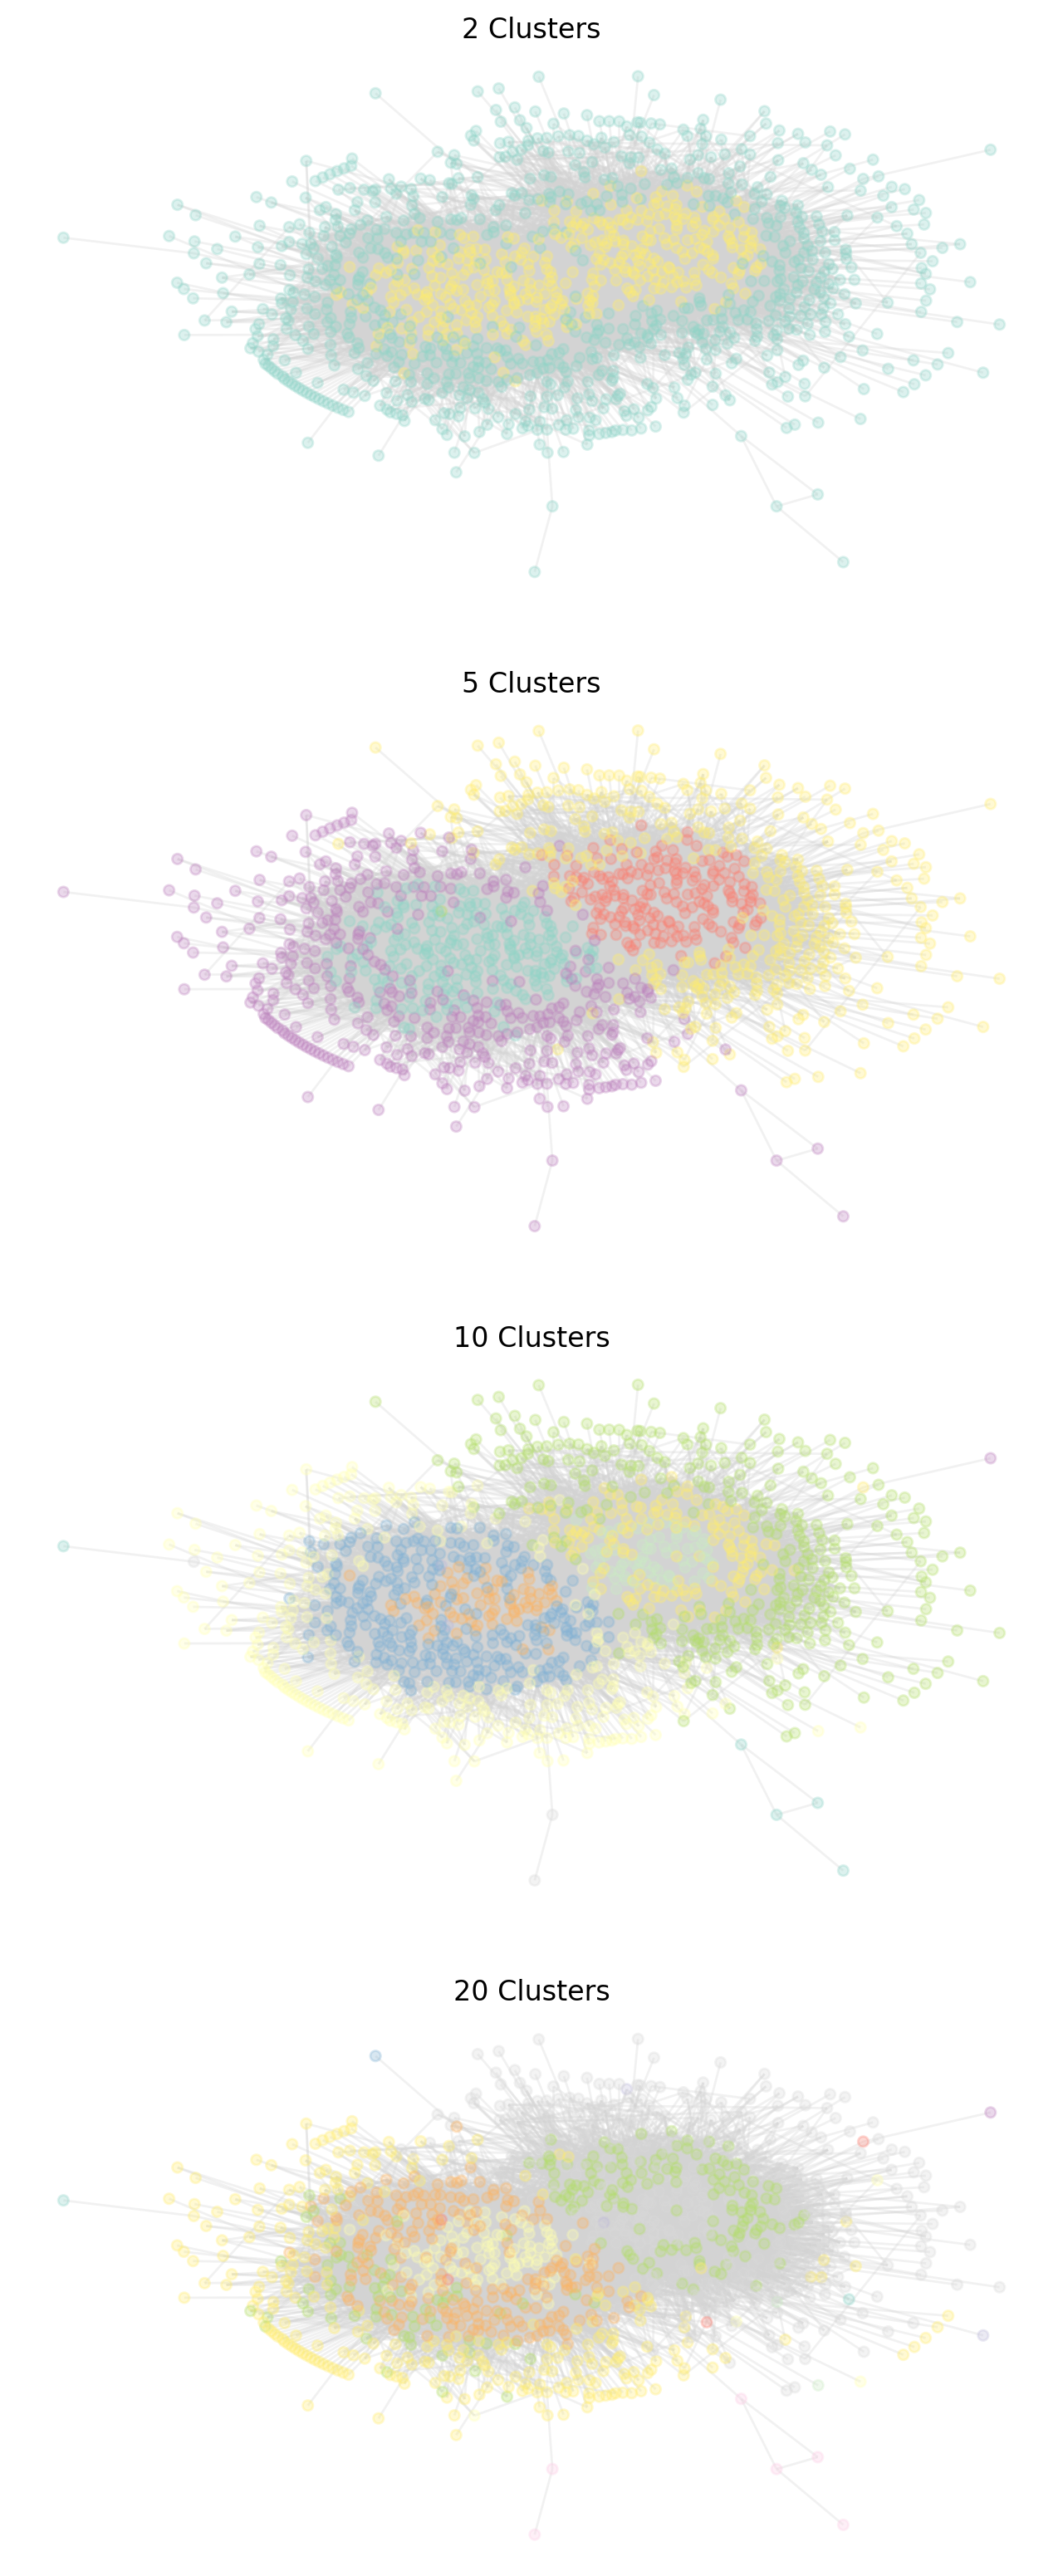

In [31]:
fig, ax = plt.subplots(4,1, figsize=(8, 20), dpi = 200)

for i, r in enumerate(results):
    templabeldict = dict(zip(sorted(G.nodes), r))
    templabels = [templabeldict[x] for x in G.nodes]
    ax[i].set_title(f"{ks[i]} Clusters")
    nx.draw_kamada_kawai(G, alpha=0.3, node_size = 20, node_color=templabels, edge_color = "lightgrey", cmap = plt.cm.Set3, ax=ax[i])
    

From the graph, we can see that spectal clustering wants to make concentric circles at K = 2, but that's not good in this case. However, giving the algorithm more clusters to work with, we see that it accurately divides the 2 main clusters, and then groups those clusters into concentric clusters. This might make sense intutively--the 2 main cluster represent right vs left leaning blogs, while the concentric clusters could represent levels of extremism in the view points (this is just a theory--we'd need to know a little more theory or domain knowledge to draw this sort of conclusion).

We can also tell from the analysis that most of the blogs are pretty tightly related--there are very few that are sparsely connected. This makes sense given the nature of web links and their ability to boost google rankings.